# QTN + Trotterization Noisy Simulation:

Using qiskit noisy FakeBackend FakeManilaV2

In this notebook we perform simulation with noise, several methods are available like importing the noise model of a specific backend from qiskit ibm runtime service, or using a noisy qiskit fake backend as in our solution, or building a noise model from scratch.

To have a realistic noise model we will use the fake backends from qiskit instead of building our own one from scratch. Also, as importing from the ibm runtime service requires an account, we will proceed only with the fake backend as it does not require an online account.

### Outline:
<ol>
<li>Required imports.</li>
<li>Backend.</li>
<li>Building the QTN+trotterization circuit.</li>
<li>DD: Dynamic decoupling error mitigation.</li>
<li>ZNE.</li>
<li>Comparison table.</li>
<li>Versions.</li>
</ol>

In [44]:
#!pip install qiskit

In [45]:
#!pip install qiskit-aer

In [46]:
#!pip install qiskit-ibm-runtime

### Required imports:

In [47]:
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Backend:

The following table shows a comparison between using the noise model from an online backend and from a fake backend and it also clearly mentions that both noise models do not resemble all errors in the real QPU like crosstalk and non-Markovian drift.

<table>
  <thead>
    <tr>
      <th>Aspect</th>
      <th><code>from_backend</code></th>
      <th>Fake Backend (snapshot)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Gate and readout errors</td>
      <td>Latest calibration from hardware</td>
      <td>Hard-coded from an older snapshot</td>
    </tr>
    <tr>
      <td>T₁/T₂ relaxation</td>
      <td>Current device parameters</td>
      <td>Hard-coded from an older snapshot</td>
    </tr>
    <tr>
      <td>Crosstalk / correlated errors</td>
      <td>Not included</td>
      <td>Not included</td>
    </tr>
    <tr>
      <td>Non-Markovian drift</td>
      <td>Not captured</td>
      <td>Not captured</td>
    </tr>
    <tr>
      <td>Snapshot freshness</td>
      <td>Always up-to-date</td>
      <td>Only updated if you call <code>refresh()</code></td>
    </tr>
  </tbody>
</table>


In [48]:
# Get a fake backend from the fake provider
backend = FakeManilaV2() # 5 qubits

The following 2 cells show the Readout errors and T1 and T2 errors at each qubit. T₁ is the energy‐relaxation time constant governing amplitude‐damping errors, where a qubit in |1⟩ decays to |0⟩ at rate 1/T₁. T₂ is the dephasing time constant governing phase‐flip errors, where the off-diagonal coherence terms decay at rate 1/T₂. Together, T₁ and T₂ set the decoherence limits that constrain gate fidelity and algorithm runtimes on real quantum hardware.

In [49]:
properties = backend.properties()
for qubit in range(backend.num_qubits):
    # Find the T1 and T2 entries in the properties for this qubit
    entries = properties.qubits[qubit]
    t1 = next(item.value for item in entries if item.name == "T1")
    t2 = next(item.value for item in entries if item.name == "T2")
    print(f"Qubit {qubit}: T1 = {t1:.2e} s, T2 = {t2:.2e} s")

Qubit 0: T1 = 1.32e+02 s, T2 = 1.02e+02 s
Qubit 1: T1 = 1.25e+02 s, T2 = 7.90e+01 s
Qubit 2: T1 = 1.59e+02 s, T2 = 2.52e+01 s
Qubit 3: T1 = 1.79e+02 s, T2 = 5.44e+01 s
Qubit 4: T1 = 1.45e+02 s, T2 = 4.03e+01 s


In [50]:
for qubit in range(backend.num_qubits):
    ro_err = properties.readout_error(qubit)
    print(f"Qubit {qubit}: average readout error = {ro_err:.2%}")

Qubit 0: average readout error = 3.53%
Qubit 1: average readout error = 2.19%
Qubit 2: average readout error = 9.64%
Qubit 3: average readout error = 1.44%
Qubit 4: average readout error = 1.86%


The following table shows the error rates for different gates on different qubits. The next cell can be uncommented to show the same results, but since the result is a little big and messy they were organized in a clear and neat table.

| Gate    | Qubits   | Gate Error               |
|---------|----------|--------------------------|
| id0     | [0]      | 0.00015506593900605392   |
| id1     | [1]      | 0.000392193487309583     |
| id2     | [2]      | 0.0007458158897263205    |
| id3     | [3]      | 0.00021221916498544087   |
| id4     | [4]      | 0.0003538722158551261    |
| rz0     | [0]      | 0                        |
| rz1     | [1]      | 0                        |
| rz2     | [2]      | 0                        |
| rz3     | [3]      | 0                        |
| rz4     | [4]      | 0                        |
| sx0     | [0]      | 0.00015506593900605392   |
| sx1     | [1]      | 0.000392193487309583     |
| sx2     | [2]      | 0.0007458158897263205    |
| sx3     | [3]      | 0.00021221916498544087   |
| sx4     | [4]      | 0.0003538722158551261    |
| x0      | [0]      | 0.00015506593900605392   |
| x1      | [1]      | 0.000392193487309583     |
| x2      | [2]      | 0.0007458158897263205    |
| x3      | [3]      | 0.00021221916498544087   |
| x4      | [4]      | 0.0003538722158551261    |
| cx4_3   | [4,3]    | 0.005696275468624307     |
| cx3_4   | [3,4]    | 0.005696275468624307     |
| cx2_3   | [2,3]    | 0.011354122839193792     |
| cx3_2   | [3,2]    | 0.011354122839193792     |
| cx1_2   | [1,2]    | 0.01394038580879381      |
| cx2_1   | [2,1]    | 0.01394038580879381      |
| cx0_1   | [0,1]    | 0.008827712070629129     |
| cx1_0   | [1,0]    | 0.008827712070629129     |


In [51]:
#for gate in properties.gates:
#    print(f"Gate: {gate.name}, Qubits: {gate.qubits}")
#    for param in gate.parameters:
#        if param.name == 'gate_error':
#            print(f"  Gate error: {param.value}")

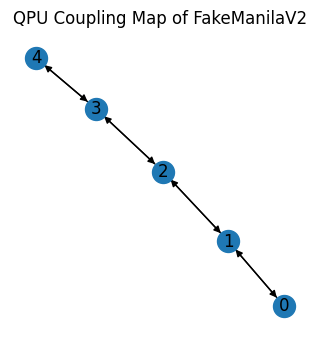

In [52]:
plt.figure(figsize=(3,3))
nx.draw(nx.DiGraph(backend.configuration().coupling_map), with_labels=True, node_size=250);
plt.title("QPU Coupling Map of FakeManilaV2");
plt.show()

### Building the QTN+trotterization circuit:

The circuit to run consists of two parts, the MPS circuit which uses QTN to encode the starting state and the trotter circuit which contains the operator that performs trotterization.

So we will import these two circuits from a prepared qasm file and we will append the trotter circuit to the MPS circuit.

In [53]:
# Trotter circuit
qasm_path = "/content/LieTrotter_operator_4.qasm"   # path to your QASM2 file
with open(qasm_path, "r") as f:
    qasm_str = f.read()

qc2 = QuantumCircuit.from_qasm_str(qasm_str)

In [54]:
# MPS circuit
qasm_path = "/content/MPS_Circuit_4.qasm"   # path to your QASM2 file
with open(qasm_path, "r") as f:
    qasm_str = f.read()

qc1 = QuantumCircuit.from_qasm_str(qasm_str)

In [55]:
qc = qc1.compose(qc2)

In [56]:
print(qc.num_qubits)

4


We would like to compare for three steps, so we will make three circuits. If we want to perform 3 steps, we start with the MPS circuit and we append the trotter circuit 3 times to it. So the trotter operator is performed 3 times. For dirichlet boundaries, we have explained in a previous notebook that we are enforcing it every couple of steps and not at every step. As if we do so, we will need after each step to re-encode the MPS circuit again after getting the statevector and this will make the errors for building the initial state accumulate with each step.

We were enforcing dirichlet after each 10 steps, and since we are using here 1, 2 and 3 steps, we just enforce after we finish all the steps as the number of steps is less than 10.

In [57]:
qc_1_step = qc.copy()
qc_2_steps = qc_1_step.compose(qc2)
qc_3_steps = qc_2_steps.compose(qc2)

Now we transpile the circuits for the fake backend, FakeManilaV2 and we show the depth and gate counts for each of the 3 circuits.

In [58]:
layout = [0, 1, 2, 3]
qc_1_step_t = transpile(qc_1_step, backend=backend, initial_layout=layout) # _t means transpiled
qc_2_steps_t = transpile(qc_2_steps, backend=backend, initial_layout=layout)
qc_3_steps_t = transpile(qc_3_steps, backend=backend, initial_layout=layout)

In [59]:
print("Depth of 1 step = ", qc_1_step_t.depth())
print("Gates for 1 step: ", qc_1_step_t.count_ops())

print("Depth of 2 steps = ", qc_2_steps_t.depth())
print("Gates for 2 steps: ", qc_2_steps_t.count_ops())

print("Depth of 3 steps = ", qc_3_steps_t.depth())
print("Gates for 3 steps: ", qc_3_steps_t.count_ops())

Depth of 1 step =  104
Gates for 1 step:  OrderedDict([('rz', 89), ('sx', 55), ('cx', 50), ('x', 5)])
Depth of 2 steps =  203
Gates for 2 steps:  OrderedDict([('rz', 170), ('sx', 103), ('cx', 100), ('x', 11)])
Depth of 3 steps =  302
Gates for 3 steps:  OrderedDict([('rz', 251), ('sx', 151), ('cx', 150), ('x', 17)])


We will save now the ideal state before running with noise for later comparison to find the L2 error.

In [60]:
ideal_psi_1 = Statevector(qc_1_step).data
ideal_psi_2 = Statevector(qc_2_steps).data
ideal_psi_3 = Statevector(qc_3_steps).data

### DD: Dynamic decoupling error mitigation

Dynamic decoupling is a pulse-sequence technique that repeatedly flips a qubit’s state to average out unwanted interactions with its environment. By carefully timing these flips, low-frequency noise and drift in the control fields get “refocused,” much like a spin-echo in NMR experiments.

In [61]:
target = backend.target
basis_gates = list(target.operation_names)

In [62]:
backend.configuration().n_qubits

5

To perform dynamic decoupling we use the following sequence [X, Y, X, Y]. In fact, the Y gate is not a basis gate of this device so we add it to the device properties and we give the "Y" gate the same duration and error as the "X" gate.

In [63]:
X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

We will start first by running the circuits on the noisy backend without dynamic decoupling or any other error mitigation technique. This will help us find if DD and ZNE provided any advantages when compared to circuits having DD or ZNE applied to it.

For each circuit, we calculate the counts and we build the final statevector from the counts.

In [64]:
n = 4
grid_points = 2**n
shots = 1000

In [65]:
# 1 step
creg = ClassicalRegister(4)
qcirc1 = qc_1_step_t.copy()
qcirc1.add_register(creg)
qcirc1.measure([0, 1, 2, 3], [0, 1, 2, 3])
job = backend.run(qcirc1, shots=1000)
counts1 = job.result().get_counts()

psi1 = np.array([counts1.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi1 = np.sqrt(psi1/shots)
psi1 = psi1 / np.linalg.norm(psi1) if np.linalg.norm(psi1) > 0 else psi1

psi1

array([0.70992957, 0.2       , 0.24494897, 0.12247449, 0.23664319,
       0.11401754, 0.18439089, 0.09486833, 0.18165902, 0.10488088,
       0.18165902, 0.11401754, 0.30166206, 0.11401754, 0.24899799,
       0.11401754])

In [66]:
# 2 steps
creg = ClassicalRegister(4)
qcirc2 = qc_2_steps_t.copy()
qcirc2.add_register(creg)
qcirc2.measure([0, 1, 2, 3], [0, 1, 2, 3])
job = backend.run(qcirc2, shots=1000)
counts2 = job.result().get_counts()

psi2 = np.array([counts2.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi2 = np.sqrt(psi2/shots)
psi2 = psi2 / np.linalg.norm(psi2) if np.linalg.norm(psi2) > 0 else psi2

psi2

array([0.53572381, 0.2236068 , 0.2607681 , 0.16733201, 0.29664794,
       0.13784049, 0.25495098, 0.14832397, 0.23874673, 0.14142136,
       0.2258318 , 0.12649111, 0.32557641, 0.12649111, 0.27748874,
       0.17320508])

In [67]:
# 3 steps
creg = ClassicalRegister(4)
qcirc3 = qc_3_steps_t.copy()
qcirc3.add_register(creg)
qcirc3.measure([0, 1, 2, 3], [0, 1, 2, 3])
job = backend.run(qcirc3, shots=1000)
counts3 = job.result().get_counts()

psi3 = np.array([counts3.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi3 = np.sqrt(psi3/shots)
psi3 = psi3 / np.linalg.norm(psi3) if np.linalg.norm(psi3) > 0 else psi3

psi3

array([0.44271887, 0.25298221, 0.31780497, 0.20493902, 0.26267851,
       0.15491933, 0.2258318 , 0.18439089, 0.24899799, 0.18708287,
       0.24289916, 0.13416408, 0.30659419, 0.18708287, 0.26457513,
       0.21447611])

In the following cells, we will run and compare the results for each step with its ideal vector calculated before and with the noisy run without dynamic decoupling. The steps are as follow for each circuit of the 3 circuits. Of course all circuits with dynamic decoupling added to it and we will run on the noisy backend.

<ol>
<li>Run the circuit and get the counts.</li>
<li>Build the statevector from the counts.</li>
<li>Compare the noisy statevector to the ideal statevector and the noisy without DD using the L2 error.</li>
</ol>

In [68]:
dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)

In [69]:
# 1 step
creg = ClassicalRegister(4)
qcirc1dd = dd_pm.run(qc_1_step_t)
qcirc1dd.add_register(creg)
qcirc1dd.measure([0, 1, 2, 3], [0, 1, 2, 3])
job = backend.run(qcirc1dd, shots=1000)
counts1dd = job.result().get_counts()

psi1dd = np.array([counts1dd.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi1dd = np.sqrt(psi1dd/shots)
psi1dd = psi1dd / np.linalg.norm(psi1dd) if np.linalg.norm(psi1dd) > 0 else psi1dd

psi1dd

array([0.6074537 , 0.18708287, 0.27568098, 0.15491933, 0.32710854,
       0.14142136, 0.21447611, 0.1183216 , 0.23664319, 0.12247449,
       0.18439089, 0.07745967, 0.32249031, 0.12247449, 0.2258318 ,
       0.16733201])

In [70]:
# 2 steps
creg = ClassicalRegister(4)
qcirc2dd = dd_pm.run(qc_2_steps_t)
qcirc2dd.add_register(creg)
qcirc2dd.measure([0, 1, 2, 3], [0, 1, 2, 3])
job = backend.run(qcirc2dd, shots=1000)
counts2dd = job.result().get_counts()

psi2dd = np.array([counts2dd.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi2dd = np.sqrt(psi2dd/shots)
psi2dd = psi2dd / np.linalg.norm(psi2dd) if np.linalg.norm(psi2dd) > 0 else psi2dd

psi2dd

array([0.41833001, 0.21447611, 0.27568098, 0.18973666, 0.29832868,
       0.14491377, 0.27018512, 0.18165902, 0.26832816, 0.14832397,
       0.27568098, 0.18439089, 0.32710854, 0.17320508, 0.28106939,
       0.17606817])

In [71]:
# 3 steps
creg = ClassicalRegister(4)
qcirc3dd = dd_pm.run(qc_3_steps_t)
qcirc3dd.add_register(creg)
qcirc3dd.measure([0, 1, 2, 3], [0, 1, 2, 3])
job = backend.run(qcirc3dd, shots=1000)
counts3dd = job.result().get_counts()

psi3dd = np.array([counts3dd.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
psi3dd = np.sqrt(psi3dd/shots)
psi3dd = psi3dd / np.linalg.norm(psi3dd) if np.linalg.norm(psi3dd) > 0 else psi3dd

psi3dd

array([0.35637059, 0.20736441, 0.3082207 , 0.20736441, 0.28635642,
       0.20736441, 0.2792848 , 0.18165902, 0.29664794, 0.18708287,
       0.27202941, 0.17888544, 0.29154759, 0.18165902, 0.26645825,
       0.19493589])

Now, we will first print the depth and gate counts with DD, then we will compare the results of L2 error to see if DD gave any clear gain.

In [72]:
print("Depth of 1 step with dd = ", qcirc1dd.depth())
print("Gates for 1 step with dd: ", qcirc1dd.count_ops())

print("Depth of 2 steps with dd = ", qcirc2dd.depth())
print("Gates for 2 steps with dd : ", qcirc2dd.count_ops())

print("Depth of 3 steps with dd = ", qcirc3dd.depth())
print("Gates for 3 steps with dd : ", qcirc3dd.count_ops())

Depth of 1 step with dd =  230
Gates for 1 step with dd:  OrderedDict([('delay', 176), ('rz', 89), ('x', 73), ('y', 68), ('sx', 55), ('cx', 50), ('measure', 4)])
Depth of 2 steps with dd =  449
Gates for 2 steps with dd :  OrderedDict([('delay', 355), ('rz', 170), ('x', 149), ('y', 138), ('sx', 103), ('cx', 100), ('measure', 4)])
Depth of 3 steps with dd =  668
Gates for 3 steps with dd :  OrderedDict([('delay', 534), ('rz', 251), ('x', 225), ('y', 208), ('sx', 151), ('cx', 150), ('measure', 4)])


In [73]:
print("----------------------------------------------------------------------------------------------")
print("L2 error for 1 step between ideal and noisy = ", np.linalg.norm(ideal_psi_1 - psi1))
print("L2 error for 1 step between ideal and noisy with DD = ", np.linalg.norm(ideal_psi_1 - psi1dd))

print("----------------------------------------------------------------------------------------------")
print("L2 error for 2 steps between ideal and noisy = ", np.linalg.norm(ideal_psi_2 - psi2))
print("L2 error for 2 steps between ideal and noisy with DD = ", np.linalg.norm(ideal_psi_2 - psi2dd))

print("----------------------------------------------------------------------------------------------")
print("L2 error for 3 steps between ideal and noisy = ", np.linalg.norm(ideal_psi_3 - psi3))
print("L2 error for 3 steps between ideal and noisy with DD = ", np.linalg.norm(ideal_psi_3 - psi3dd))

----------------------------------------------------------------------------------------------
L2 error for 1 step between ideal and noisy =  0.751244016426199
L2 error for 1 step between ideal and noisy with DD =  0.8774868376827626
----------------------------------------------------------------------------------------------
L2 error for 2 steps between ideal and noisy =  0.9552954140234554
L2 error for 2 steps between ideal and noisy with DD =  1.0710063465785529
----------------------------------------------------------------------------------------------
L2 error for 3 steps between ideal and noisy =  1.0479295377070204
L2 error for 3 steps between ideal and noisy with DD =  1.1286416185343153


We can clearly see that with DD we got worse errors for all the 3 circuits instead of less error. In fact, in the next section we will find that ZNE will give a big improvement instead of increasing the errors.

### ZNE:

Zero-noise extrapolation estimates ideal quantum results by running a circuit at multiple amplified noise levels and fitting a curve to these noisy outputs. It scales noise through gate stretching or idle insertions to probe how errors grow. A polynomial (e.g., Richardson) fit then predicts the observable at zero noise. In our case we will apply ZNE on the values of the statevector.

In [74]:
def global_fold_zne(circuit: QuantumCircuit, n: int, backend):
    """
    Return the statevector built from the counts for n folds.

    The resulting circuit implements C (C† C)^(n//2), preserving the logical action
    of C while amplifying its noise by a specific factor.

    Parameters:
      circuit: QuantumCircuit
        The original circuit C you want to fold.
      n: int
        Number of full-fold repetitions.

    Returns:
      ndarray
        Statevector representing the vector psi.
    """
    # start with one copy of C
    folded = circuit.copy()

    # each iteration appends C† then C
    for _ in range(n//2):
        folded.compose(circuit.inverse(), inplace=True)
        folded.compose(circuit, inplace=True)
    creg = ClassicalRegister(4)
    folded.add_register(creg)

    # Now you can measure
    folded.measure([0, 1, 2, 3], [0, 1, 2, 3])
    job = backend.run(folded, shots=1000)
    counts = job.result().get_counts()

    n = 4
    grid_points = 2**n
    shots = 1000
    psi = np.array([counts.get(bin(i).replace('0b', '').zfill(n), 0) for i in range(grid_points)])
    psi = np.sqrt(psi/shots)
    psi = psi / np.linalg.norm(psi) if np.linalg.norm(psi) > 0 else psi

    return psi

In the following cells we will apply ZNE on the 3 circuits and we will compare the L2 error before and after ZNE for each circuit, we will also plot the resulting plots for the first circuit only (first step).

In [75]:
# 1 step

In [76]:
psi1_n3 = global_fold_zne(circuit=qc_1_step_t, n=3, backend=backend) # folding n = 3
psi1_n5 = global_fold_zne(circuit=qc_1_step_t, n=5, backend=backend) # folding n = 5
psi1_n7 = global_fold_zne(circuit=qc_1_step_t, n=7, backend=backend) # folding n = 7

psi1_zne = (35*psi1 - 35*psi1_n3 + 21*psi1_n5 - 5*psi1_n7) / 16
x1 = np.linalg.norm(ideal_psi_1 - psi1)
y1 = np.linalg.norm(ideal_psi_1 - psi1_zne)

print("L2 error for 1 step between ideal and noisy = ", x1)
print("L2 error for 1 step with zne = ", y1)
print("L2 error percentage improvement = ", 100 - y1/x1*100, "%" )

L2 error for 1 step between ideal and noisy =  0.751244016426199
L2 error for 1 step with zne =  0.5723135645764938
L2 error percentage improvement =  23.81788712286975 %


This formula implements a third-order Richardson extrapolation using noise scale factors 1, 3, 5, and 7. Coefficients 35, –35, 21, and –5 are chosen so that error terms up to cubic order cancel when summed. Dividing the weighted sum by 16 normalizes it to yield the zero-noise estimate ψ₁_zne.


\begin{align}
\psi_{1}^{\mathrm{ZNE}} = \frac{35\,\psi_{1} \;-\; 35\,\psi_{1,n3} \;+\; 21\,\psi_{1,n5} \;-\; 5\,\psi_{1,n7}}{16}
\end{align}

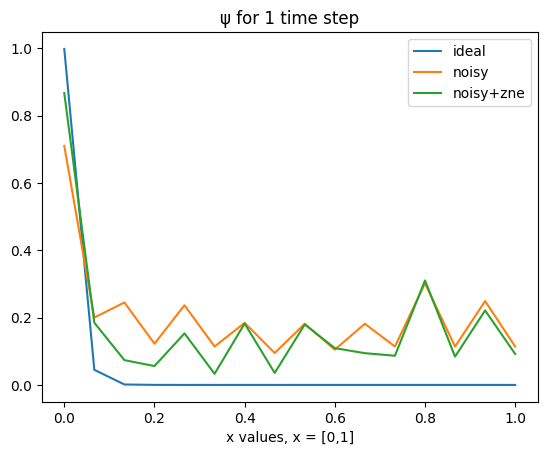

In [77]:
plt.plot(np.linspace(0, 1, 2**4), np.real(ideal_psi_1), label='ideal')
plt.plot(np.linspace(0, 1, 2**4), np.real(psi1), label='noisy')
plt.plot(np.linspace(0, 1, 2**4), np.real(psi1_zne), label='noisy+zne')
plt.title("ψ for 1 time step")
plt.xlabel("x values, x = [0,1]")
plt.legend()

In [78]:
def recover_u_from_psi(psi, dx, nu, epsilon=1e-10):
    """
    Recovers the velocity field u(x) from the scalar function psi(x) using the
    Cole-Hopf transformation, which involves calculating the spatial derivative
    of log(psi).

    The Cole-Hopf transformation is typically given by:
    u(x) = -2 * nu * (d/dx(log(psi(x))))

    This function approximates the derivative using a finite difference method.

    Args:
        psi (numpy.ndarray): A 1D NumPy array representing the scalar function psi(x).
                             It is assumed to be real-valued.
        dx (float): The spatial step size (delta x) between points in the psi array.
        nu (float): The kinematic viscosity parameter, a constant in the
                    Cole-Hopf transformation.
        epsilon (float, optional): A small positive value used to clip `psi`
                                   to prevent taking the logarithm of zero or
                                   negative numbers, which would result in
                                   NaN or infinite values. Defaults to 1e-10.

    Returns:
        numpy.ndarray: A 1D NumPy array representing the recovered velocity field u(x).
    """
    psi_clipped = np.clip(np.abs(psi), epsilon, None)
    log_psi = np.log(psi_clipped)

    dlog_psi_dx = (np.roll(log_psi, -1) - np.roll(log_psi, 1)) / (2 * dx)
    dlog_psi_dx[0] = (log_psi[1] - log_psi[0]) / dx
    dlog_psi_dx[-1] = (log_psi[-1] - log_psi[-2]) / dx

    return -2 * nu * dlog_psi_dx

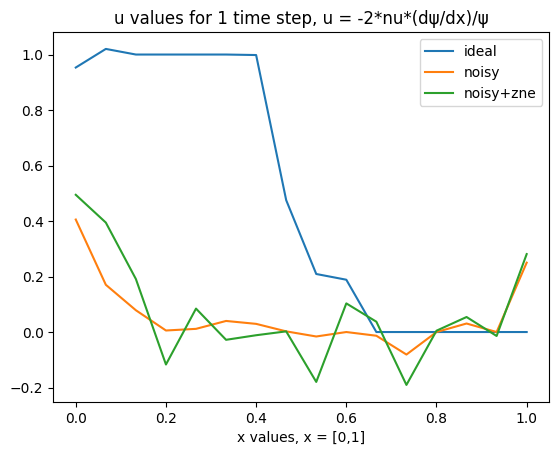

In [79]:
plt.plot(np.linspace(0, 1, 2**4), recover_u_from_psi(ideal_psi_1, 1/(2**4), 0.01), label='ideal')
plt.plot(np.linspace(0, 1, 2**4), recover_u_from_psi(psi1, 1/(2**4), 0.01), label='noisy')
plt.plot(np.linspace(0, 1, 2**4), recover_u_from_psi(psi1_zne, 1/(2**4), 0.01), label='noisy+zne')
plt.title("u values for 1 time step, u = -2*nu*(dψ/dx)/ψ")
plt.xlabel("x values, x = [0,1]")
plt.legend()

In [80]:
psi2_n3 = global_fold_zne(circuit=qc_2_steps_t, n=3, backend=backend) # folding n = 3
psi2_n5 = global_fold_zne(circuit=qc_2_steps_t, n=5, backend=backend) # folding n = 5
psi2_n7 = global_fold_zne(circuit=qc_2_steps_t, n=7, backend=backend) # folding n = 7

psi2_zne = (35*psi2 - 35*psi2_n3 + 21*psi2_n5 - 5*psi2_n7) / 16
x2 = np.linalg.norm(ideal_psi_2 - psi2)
y2 = np.linalg.norm(ideal_psi_2 - psi2_zne)

print("L2 error for 2 steps between ideal and noisy = ", x2)
print("L2 error for 2 steps with zne = ", y2)
print("L2 error percentage improvement = ", 100 - y2/x2*100, "%" )

L2 error for 2 steps between ideal and noisy =  0.9552954140234554
L2 error for 2 steps with zne =  0.8147985109086373
L2 error percentage improvement =  14.707168175662204 %


In [81]:
psi3_n3 = global_fold_zne(circuit=qc_3_steps_t, n=3, backend=backend) # folding n = 3
psi3_n5 = global_fold_zne(circuit=qc_3_steps_t, n=5, backend=backend) # folding n = 5
psi3_n7 = global_fold_zne(circuit=qc_3_steps_t, n=7, backend=backend) # folding n = 7

psi3_zne = (35*psi3 - 35*psi3_n3 + 21*psi3_n5 - 5*psi3_n7) / 16
x3 = np.linalg.norm(ideal_psi_3 - psi3)
y3 = np.linalg.norm(ideal_psi_3 - psi3_zne)

print("L2 error for 3 steps between ideal and noisy = ", x3)
print("L2 error for 3 steps with zne = ", y3)
print("L2 error percentage improvement = ", 100 - y3/x3*100, "%" )

L2 error for 3 steps between ideal and noisy =  1.0479295377070204
L2 error for 3 steps with zne =  0.9274730298010342
L2 error percentage improvement =  11.494714441350467 %


### Comparison table:

<table border="1">
  <thead>
    <tr>
      <th></th>
      <th>Steps</th>
      <th>Depth</th>
      <th>1 qubit gates</th>
      <th>2 qubit gates</th>
      <th>Average T1</th>
      <th>Average T2</th>
      <th>Average readout error</th>
      <th>1 qubit gates error</th>
      <th>2 qubit gates error</th>
      <th>L2 error</th>
      <th>% improvement</th>
    </tr>
  </thead>
  <tbody>
    <!-- first block: first‐col row 1 of 3 -->
    <tr>
      <td rowspan="3">Without error mitigation</td>
      <td>1</td><td>104</td><td>149</td><td>50</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>0.751</td><td>-</td>
    </tr>
    <tr>
      <td>2</td><td>203</td><td>284</td><td>100</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>0.955</td><td>-</td>
    </tr>
    <tr>
      <td>3</td><td>302</td><td>419</td><td>150</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>1.047</td><td>-</td>
    </tr>
    <!-- first block: first‐col row 1 of 3 -->
    <tr>
      <td rowspan="3">Dynamic decoupling</td>
      <td>1</td><td>230</td><td>465</td><td>50</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>0.877</td><td>no improvement</td>
    </tr>
    <tr>
      <td>2</td><td>449</td><td>919</td><td>100</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>1.071</td><td>no improvement</td>
    </tr>
    <tr>
      <td>3</td><td>668</td><td>1373</td><td>150</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>1.128</td><td>no improvement</td>
    </tr>
    <!-- first block: first‐col row 1 of 3 -->
    <tr>
      <td rowspan="3">Zero noise extrapolation</td>
      <td>1</td><td>n*104</td><td>149n</td><td>50n</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>0.572</td><td>23.8178%</td>
    </tr>
    <tr>
      <td>2</td><td>n*203</td><td>284n</td><td>100n</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>0.814</td><td>14.7%</td>
    </tr>
    <tr>
      <td>3</td><td>n*302</td><td>419n</td><td>150n</td>
      <td>148s</td><td>60.18s</td><td>3.73%</td><td>0.37183e-3</td><td>9.95e-3</td><td>0.927</td><td>11.49%</td>
    </tr>
  </tbody>
</table>


Several things worth mentioning in the above table. First, in ZNE, n is the number of folds.

Second, since each qubit has its T1, T2 and 1 qubit gate error, the value was averaged from all the values, the same for 2 qubit gates.

In addition to that, although we have decreased the error by around 24% max for 1 step, the plots still do not look very good especially for u, while for $\psi$ looks good.

More errors should be applied in the future like readout error mitigation and the advancement in hardware especially error rates will be of great benefit also.

### Versions:

In [82]:
# python version
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [83]:
import pkg_resources

# Loop through installed packages and filter those starting with 'qiskit'
for dist in pkg_resources.working_set:
    if dist.project_name.lower().startswith("qiskit"):
        print(f"{dist.project_name} == {dist.version}")

qiskit == 2.1.1
qiskit-aer == 0.17.1
qiskit-ibm-runtime == 0.41.0
